# Model

The model from Saiz et al has three parts in the model

## Mechanics

The cells are spheroids that behave under the following equations:

$$
m_i\frac{dv_i}{dt} =-bv_i+\sum_j F_{ij}
$$
$$
\frac{dx_i}{dt} =v_i
$$

where the force is

$$
F_{ij}=
\begin{cases}
F_0(\frac{r_{ij}}{d_{ij}}-1)(\frac{\mu r_{ij}}{d_{ij}}-1)\frac{(x_i-x_j)}{d_{ij}}\hspace{1cm}if\;d_{ij}<\mu r_{ij}\\
0\hspace{5cm}otherwise
\end{cases}
$$

where $d_{ij}$ is the Euclidean distance and $r_{ij}$ is the sum of both radius.

## Biochemical interaction

Each cell has a biochemical component that follows an equation of the form:

$$
\frac{dx_i}{dt}=\frac{α(1+x^n_i)^m}{(1+x^n_i)^m+(1+(\langle x\rangle_i)/K)^{2m}}-x_i
$$

This is similar to the above case. The only detail required is to note that the average expression can be modeled as the combination of two interacting variables. The biochemical system is activated in the interval $[t_{on},t_{off}]$.

We made explicit that the average operator can be written as two interaction parameters that are the contraction along the second index that runs over the neighbours of each cell as,

$$
N_{ij}=
\begin{cases}
1\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}
$$

$$
X_{ij}=
\begin{cases}
x_j\hspace{1cm}d<f_{range}r_{ij}\\
0\hspace{1cm}otherwise
\end{cases}
$$

$$
\langle x\rangle_i=\frac{\sum_j X_{ij}}{\sum_j N_{ij}}=\frac{X_{i}}{N_{i}}
$$

## Growth

The cells present division. The rules for the division in this model are. Random election of a division direction over the unit sphere. The daughter cells divide equally in mass and volume and are positioned in oposite directions around the division axis centered at the parent cell. The chemical concentration is divided asymmetrically with each cell taking $1\pm\sigma_x \text{Uniform}(0,1)$ for the parent cell. A new division time is assigned to each aghter cell from a uniform distribution $\text{Uniform}(\tau_{div}(1-\sigma_{div}),\tau_{div}(1+\sigma_{div}))$.

# Implementation of the model

In [2]:
using AgentBasedModels
abm = AgentBasedModels

using Random
using Distributions
using CUDA

using GLMakie

# Define the agent

In [3]:
m = @agent(3,
    
    #Mechanics
    
    [vx,vy,vz]::Local, #Variables
    [Fix,Fiy,Fiz]::Local,    #Interaction forces
    [m,r]::Local,            #Mass and radius of the model
    [μ,b]::Global,           #Global parameters of the model
    F₀::Global,         #Matrix of interaction forces
    
    Equation = begin
        d_vx = (-b*vx/m+Fix/m)*dt
        d_vy = (-b*vy/m+Fiy/m)*dt
        d_vz = (-b*vz/m+Fiz/m)*dt
        d_x = vx*dt
        d_y = vy*dt
        d_z = vz*dt
    end,
    
    UpdateInteraction = begin
        dij = sqrt((x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2)
        rij = r_i+r_j
        if dij < μ*rij && dij > 0
            Fix += F₀*(rij/dij-1)*(μ*rij/dij-1)*(x_i-x_j)/dij
            Fiy += F₀*(rij/dij-1)*(μ*rij/dij-1)*(y_i-y_j)/dij
            Fiz += F₀*(rij/dij-1)*(μ*rij/dij-1)*(z_i-z_j)/dij   
        end
    end,
    
    #Biochemistry
    
    c::Local,             #Biochemical component
    [ci,ni]::Local,       #Interaction parameters for the mean
    toff::Local,
    [α,n,mm,K]::Global,
    [frange,fmin,fmax]::Global,       #Distance of communication
    Non::Global,
    
    Equation = begin
        if t < toff && N > Non
            d_c = (α*(1+c^n)^mm/((1+c^n)^mm+(1+(ci/ni)/K)^(2*mm))-c)*dt
        else
            d_c = 0*dt
        end
    end,
        
    UpdateInteraction= begin
        if dij < frange*rij #Unnecessary to compute dij and rij again, previously computed in UpdateInteraction
            ni += 1
            ci += c_j
        end 
    end,
    
    #Growth
    
    tu::Local,
    [τdiv,σdiv,σc]::Global,

    EventDivision = begin
        if t > tu
            #Choose random direction in unit sphere
            xₐ = Normal(0,1); yₐ = Normal(0,1); zₐ = Normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution
            dist = Uniform(1-σc,1+σc)

            #Update things of first cell
            x_1 = x+r*xₐ/2; y_1 = y+r*yₐ/2; z_1 = z+r*zₐ/2
            vx_1 = 0.; vy_1 = 0.; vz_1 = 0.
            r_1 = r/2. ^(1. /3)
            m_1 = m/2
            tu_1 = t + Uniform(τdiv-σdiv,τdiv+σdiv)
            c_1 = c*dist

            #Update things of second cell
            x_2 = x-r*xₐ/2; y_2 = y-r*yₐ/2; z_2 = z-r*zₐ/2
            vx_2 = 0.; vy_2 = 0.; vz_2 = 0.
            r_2 = r/2. ^(1. /3)
            m_2 = m/2
            tu_2 = t + Uniform(τdiv-σdiv,τdiv+σdiv)
            c_2 = c*(2-dist)
        end
    end,
);

# Compile the model

In [4]:
mCompiled = compile(m,platform="cpu",save="RAM",integrator="Heun",debug=false);

# Initialise the Community

In [5]:
com = Community(mCompiled,N=1)

##########Mechanics##############################
#Initialise global
com.b = 10^-6
com.F₀ = 10^-4 #.*zeros(2,2)
com.μ = 2

#########Division#################################
#Initialise global
com.τdiv = 10
com.σdiv = 0.5
com.σc = 0.01

#########Chemical#################################
#Initialise Global
com.Non = 3 #Start deactivated
com.fmin = 0.05
com.fmax = 0.95
com.α = 10
com.n = 2
com.mm = 2
com.K = 0.9
com.frange = 1.2

#########Local parameters and variables###########
#Initialise locals
mᵢ = 10^-6
rᵢ = 5
com.m .= mᵢ
com.r .= rᵢ
com.id .= 1 #Start neutral fate
com.toff .= 10 #Start activated
#Initialise variables
com.x .= 0. #They are only separed in this axis
com.y .= 0.
com.z .= 0.
com.vx .= 0.
com.vy .= 0.
com.vz .= 0.

c₀=3.
com.c .= c₀
com.tu .= 10.

1-element view(::Matrix{Float64}, :, 16) with eltype Float64:
 10.0

In [6]:
c = mCompiled.evolve(com,dt=0.001,tMax=60,nMax=1000,dtSave=1);

In [7]:
c[end].N

32

## Visualization

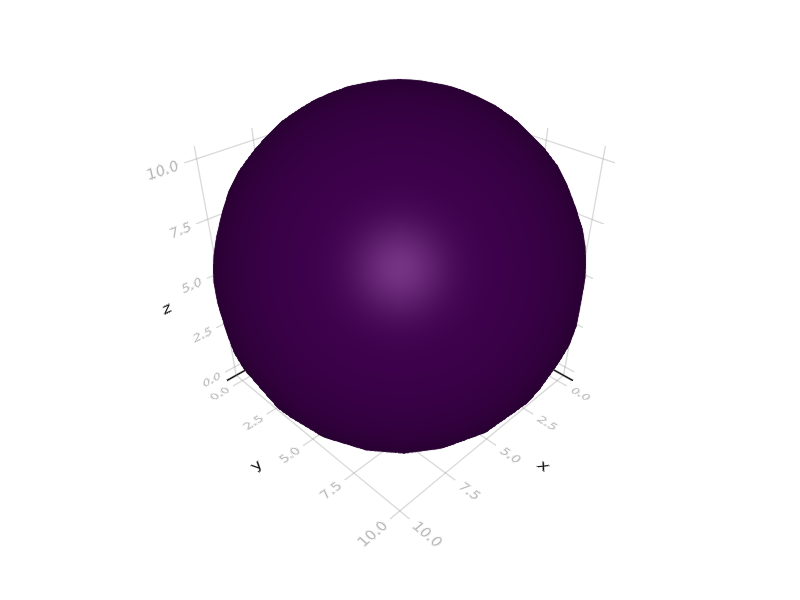

In [9]:
i = 1
x = c[i].x
y = c[i].y
z = c[i].z
r = c[i].r;
col = c[i].c;
    
fig,ax = meshscatter([0,10,0,0],[0,0,10,0],[0,0,0,10],markersize=0)
meshscatter!(ax,x.+10,y.+10,z.+10,markersize=r,color=col)

fig

## Saving images for making video

In [21]:
# times = range(1,length(c.t),step=1)
# for i in times
#     x = c[i].x
#     y = c[i].y
#     z = c[i].z
#     r = c[i].r;
#     col = c[i].c;

#     fig,ax = meshscatter([0,10,0,0],[0,0,10,0],[0,0,0,10],markersize=0)
#     meshscatter!(ax,x,y,z,markersize=r,color=col)
    
#     save(string("saiz_",i,".png"),fig)
# end